In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

In [3]:
!wget -q -P ./ https://www.dropbox.com/s/w07liww46kgxo1m/handbags-shoes.zip
!unzip -qq handbags-shoes.zip

## Data Pre-processing

In [4]:
import os, shutil, pathlib

base_dir = pathlib.Path("/content/handbags-shoes")


In [5]:
#!rm -rf /content/handbags-shoes

In [6]:
for category in ('handbags', 'shoes'):
  fnames = os.listdir(base_dir/category)
  dir = base_dir /'train' / category
  os.makedirs(dir)
  for fname in fnames[:50]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)
  dir = base_dir /'validation' / category
  os.makedirs(dir)
  for fname in fnames[50:75]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)
  dir = base_dir /'test' / category
  os.makedirs(dir)
  for fname in fnames[75:]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

In [7]:
train_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'train',
    image_size=(224, 224),
    batch_size=32)

validation_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'validation',
    image_size=(224, 224),
    batch_size=32)

test_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'test',
    image_size=(224, 224),
    batch_size=32)


Found 95 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


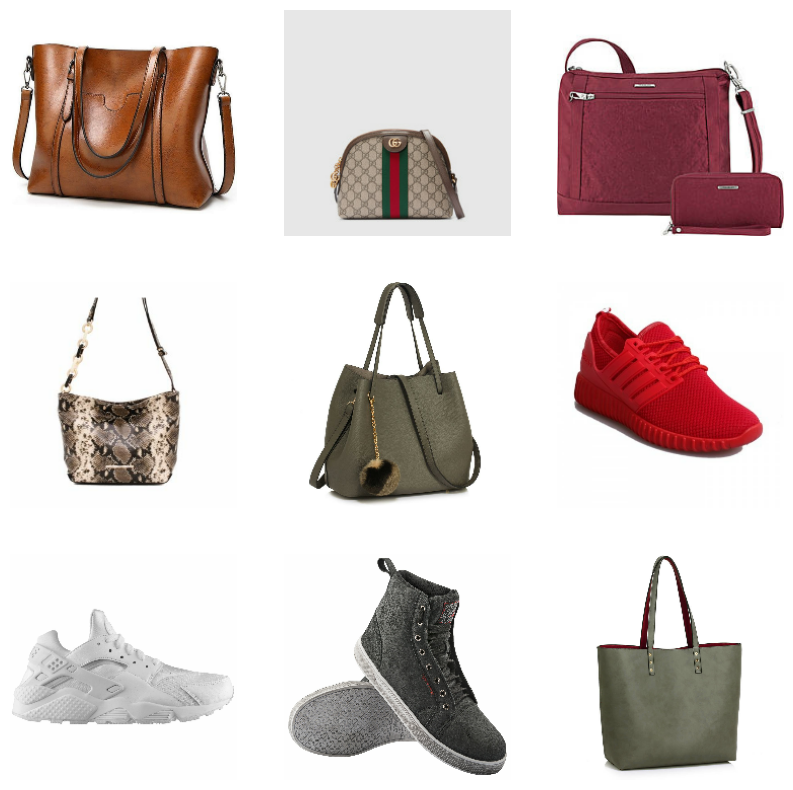

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## A Basic Convolutional Neural Network

In [9]:
input = keras.Input(shape=(224,224,3))
h = keras.layers.Rescaling(1./255)(input)


# 1st convolutional block
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_1")(h)
# pooling layer
h = keras.layers.MaxPool2D()(h)


# 2nd convolutional block
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_2")(h)
# pooling layer
h = keras.layers.MaxPool2D()(h)


h = keras.layers.Flatten()(h)
output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 Conv_2 (Conv2D)             (None, 110, 110, 32)      4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                        

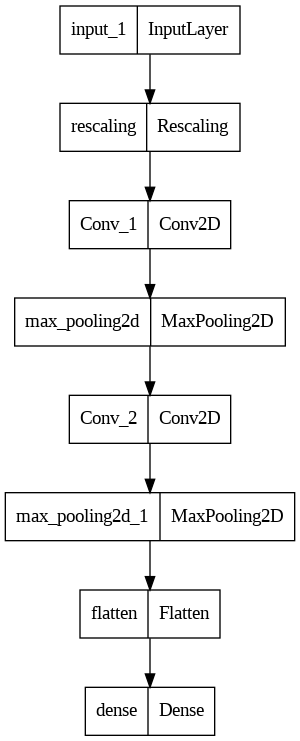

In [11]:
keras.utils.plot_model(model)

In [12]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [13]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20
3/3 [==============================] - 8s 694ms/step - loss: 1.7165 - accuracy: 0.4947 - val_loss: 1.0503 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 1s 245ms/step - loss: 1.0531 - accuracy: 0.5053 - val_loss: 0.7489 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 1s 225ms/step - loss: 0.6089 - accuracy: 0.6632 - val_loss: 0.7090 - val_accuracy: 0.5000
Epoch 4/20
3/3 [==============================] - 1s 238ms/step - loss: 0.6157 - accuracy: 0.6211 - val_loss: 0.5506 - val_accuracy: 0.6800
Epoch 5/20
3/3 [==============================] - 1s 229ms/step - loss: 0.4492 - accuracy: 0.8316 - val_loss: 0.5013 - val_accuracy: 0.7800
Epoch 6/20
3/3 [==============================] - 1s 219ms/step - loss: 0.4114 - accuracy: 0.8842 - val_loss: 0.4191 - val_accuracy: 0.8800
Epoch 7/20
3/3 [==============================] - 1s 348ms/step - loss: 0.3503 - accuracy: 0.8632 - val_loss: 0.4056 - val_accuracy: 0.8400
Epoch 8/20
3/3 [====

In [14]:
def plot_learning_curve(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

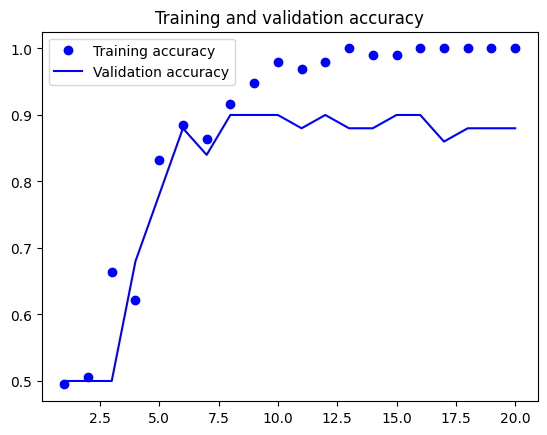

In [15]:
plot_learning_curve(history)

In [16]:
model.evaluate(test_dataset)

2/2 [==============================] - 0s 147ms/step - loss: 0.6327 - accuracy: 0.8000


[0.6327497959136963, 0.800000011920929]

## Data Augmentation for Images

In [17]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)

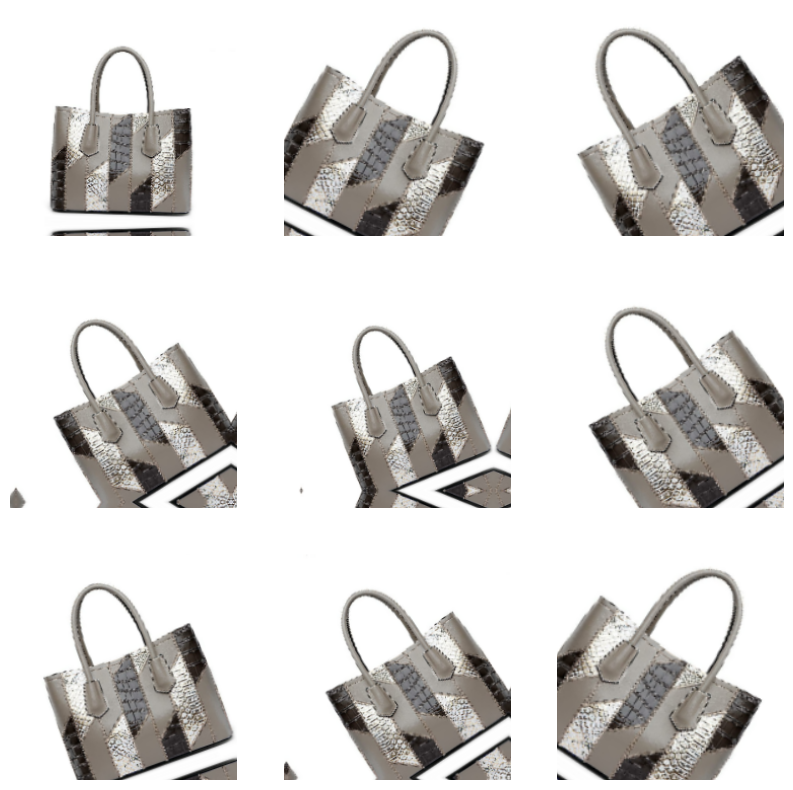

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [19]:
input = keras.Input(shape=(224,224,3))

# we have inserted the data augmentation layer here
h = data_augmentation(input)
# rest of the model is the same as before

h = keras.layers.Rescaling(1./255)(h)

# convolutional layer!
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_1")(h)
# pooling layer
h = keras.layers.MaxPool2D()(h)


# convolutional layer!
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_2")(h)
# pooling layer
h = keras.layers.MaxPool2D()(h)


h = keras.layers.Flatten()(h)
output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 Conv_2 (Conv2D)             (None, 110, 110, 32)      4128      
                                                           

In [21]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [22]:
history = model.fit(train_dataset,
                    epochs=40,
                    validation_data=validation_dataset)

Epoch 1/40
3/3 [==============================] - 3s 430ms/step - loss: 1.5764 - accuracy: 0.5263 - val_loss: 1.3563 - val_accuracy: 0.5000
Epoch 2/40
3/3 [==============================] - 1s 230ms/step - loss: 1.3475 - accuracy: 0.4947 - val_loss: 0.5348 - val_accuracy: 0.7600
Epoch 3/40
3/3 [==============================] - 2s 346ms/step - loss: 0.7788 - accuracy: 0.5474 - val_loss: 1.0016 - val_accuracy: 0.5000
Epoch 4/40
3/3 [==============================] - 1s 217ms/step - loss: 0.7606 - accuracy: 0.5474 - val_loss: 0.4908 - val_accuracy: 0.8200
Epoch 5/40
3/3 [==============================] - 1s 224ms/step - loss: 0.5629 - accuracy: 0.7053 - val_loss: 0.5640 - val_accuracy: 0.6600
Epoch 6/40
3/3 [==============================] - 1s 231ms/step - loss: 0.6598 - accuracy: 0.6421 - val_loss: 0.4918 - val_accuracy: 0.7400
Epoch 7/40
3/3 [==============================] - 1s 205ms/step - loss: 0.5562 - accuracy: 0.6947 - val_loss: 0.4558 - val_accuracy: 0.8400
Epoch 8/40
3/3 [====

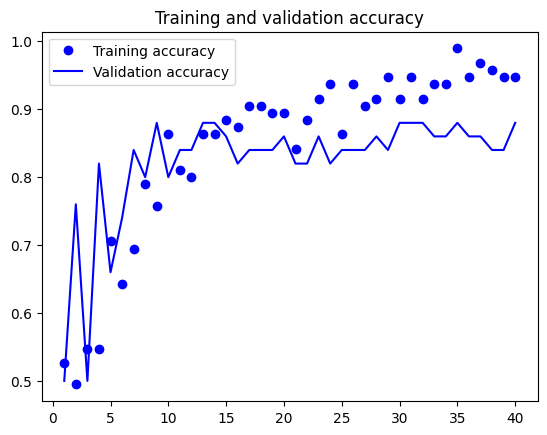

In [23]:
plot_learning_curve(history)

In [24]:
model.evaluate(test_dataset)

2/2 [==============================] - 0s 11ms/step - loss: 0.8534 - accuracy: 0.7750


[0.8534399271011353, 0.7749999761581421]

## Model built with Transfer Learning


In [25]:
resnet50_base = keras.applications.ResNet50(
  weights='imagenet',
  include_top=False,
  input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [26]:
resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

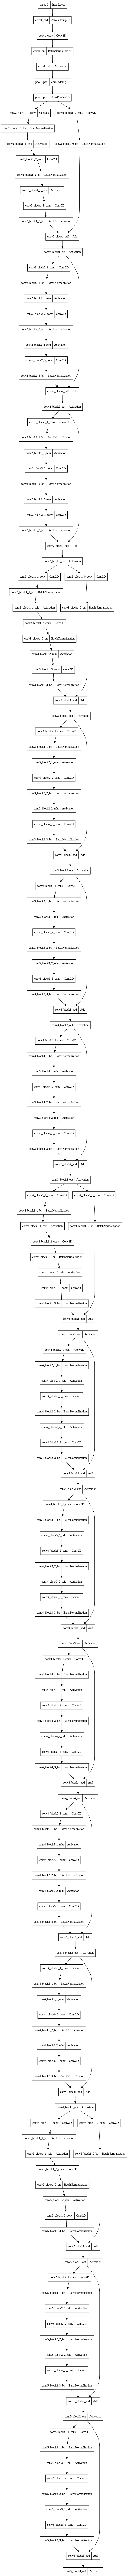

In [27]:
keras.utils.plot_model(resnet50_base)

In [28]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.resnet50.preprocess_input(images)
    features = resnet50_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

In [29]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 1s/step


In [30]:
train_features.shape

(95, 7, 7, 2048)

In [31]:
# This is the "smart" input from headless ResNet
input = keras.Input(shape=(7, 7, 2048))

# We flatten it into a vector
h = keras.layers.Flatten()(input)

# Run it through a dense layer with 256 relu neurons
h = keras.layers.Dense(256, activation="relu")(h)

# Apply dropout to 50% of the neurons
h = keras.layers.Dropout(0.5)(h)

# Run it through a single sigmoid neuron to get the prediction
output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

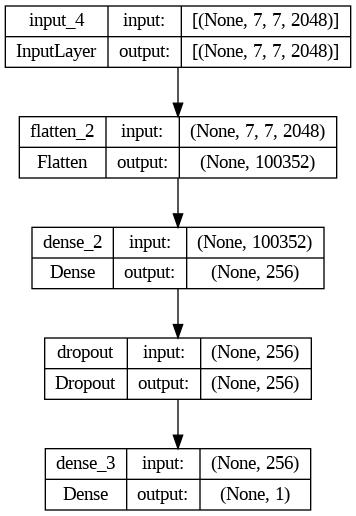

In [32]:
keras.utils.plot_model(model, show_shapes=True)

In [33]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 25690625 (98.00 MB)
Trainable params: 25690625 (98.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
  train_features, train_labels,
  epochs=10,
  validation_data=(val_features, val_labels))

Epoch 1/10
3/3 [==============================] - 2s 135ms/step - loss: 0.6390 - accuracy: 0.8316 - val_loss: 1.2499 - val_accuracy: 0.9600
Epoch 2/10
3/3 [==============================] - 0s 39ms/step - loss: 0.5167 - accuracy: 0.9789 - val_loss: 5.4697 - val_accuracy: 0.9200
Epoch 3/10
3/3 [==============================] - 0s 42ms/step - loss: 0.1826 - accuracy: 0.9895 - val_loss: 4.7602 - val_accuracy: 0.9200
Epoch 4/10
3/3 [==============================] - 0s 37ms/step - loss: 3.4369e-29 - accuracy: 1.0000 - val_loss: 3.3019 - val_accuracy: 0.9600
Epoch 5/10
3/3 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.4676 - val_accuracy: 0.9600
Epoch 6/10
3/3 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.1618 - val_accuracy: 0.9800
Epoch 7/10
3/3 [==============================] - 0s 42ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.9639 - val_accuracy: 0.9800
Epoch 8/10

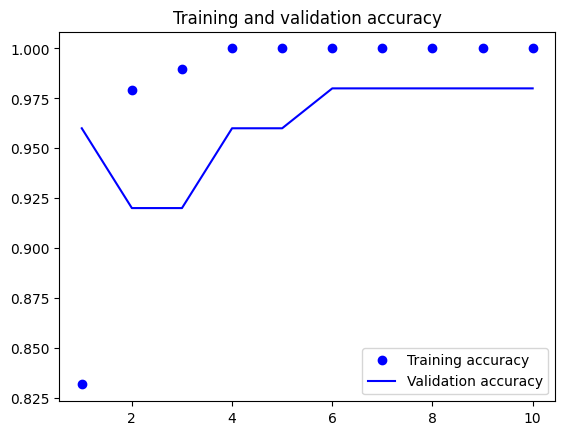

In [35]:
plot_learning_curve(history)

In [36]:
model.evaluate(test_features, test_labels)

2/2 [==============================] - 0s 11ms/step - loss: 0.3046 - accuracy: 0.9750


[0.3046117424964905, 0.9750000238418579]

In [37]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



In [38]:
def predict_image(im):
  img = keras.preprocessing.image.load_img(im, target_size=(224,224))
  arr = keras.preprocessing.image.img_to_array(img)
  arr = keras.applications.resnet50.preprocess_input(arr)
  arr = np.expand_dims(arr, axis=0)
  arr = resnet50_base(arr)
  pred = model.predict(arr)
  pred = "SHOE" if pred > 0.5 else "HANDBAG"
  print("************************************\n\n")
  print(f"...........it is a {pred}!")
  print("\n\n************************************\n\n")

<IPython.core.display.Javascript object>

Saved to photo.jpg


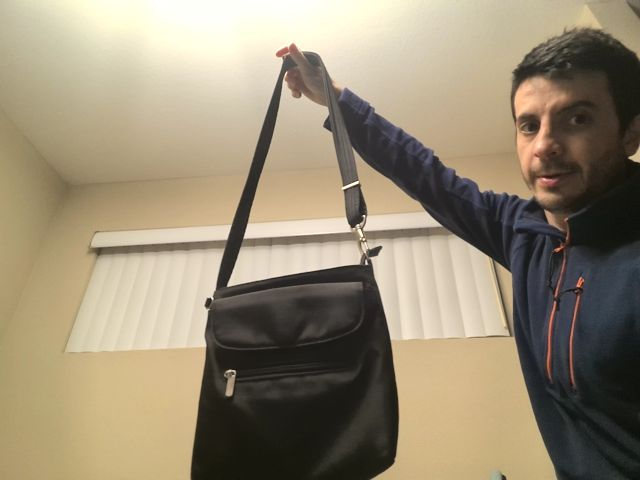

1/1 [==============================] - 0s 18ms/step
************************************


...........it is a HANDBAG!


************************************




In [40]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
  predict_image(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))